In [608]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from prettytable import PrettyTable

In [609]:
# sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from scipy.stats import mode
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [610]:
naive_sub= pd.read_parquet('data/taxi/naive_submission.parquet')
df= pd.read_parquet('data/taxi/train.parquet')
test= pd.read_parquet('data/taxi/test.parquet')

# Dataset exploration

In [611]:
print("Nombre d'observations dans les données d'entraînement:",len(df))
print("Nombre d'observations dans les données test:",len(test))

Nombre d'observations dans les données d'entraînement: 100000
Nombre d'observations dans les données test: 2627163


## Variables

In [612]:
# Toutes les variables du jeu de données
columns = list(df.columns)
columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'congestion_surcharge',
 'Airport_fee',
 'PU_location_lat',
 'PU_location_lon',
 'DO_location_lat',
 'DO_location_lon']

In [451]:
# Vérification de données manquantes
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
congestion_surcharge     0
Airport_fee              0
PU_location_lat          0
PU_location_lon          0
DO_location_lat          0
DO_location_lon          0
dtype: int64

In [ ]:
# Résumé des variables
df_summary = df.describe(include='all').T
df_summary

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
VendorID,100000.0,NaN,NaN,NaN,1.75954,1.0,2.0,2.0,2.0,2.0,0.427365
tpep_pickup_datetime,100000,NaN,NaN,NaN,2024-01-17 01:37:59.341700,2023-12-31 23:56:46,2024-01-09 15:34:38,2024-01-17 11:32:54.500000,2024-01-24 18:09:36,2024-01-31 23:59:07,NaN
tpep_dropoff_datetime,100000,NaN,NaN,NaN,2024-01-17 01:53:39.024740,2024-01-01 00:03:50,2024-01-09 15:50:20.750000,2024-01-17 11:51:50,2024-01-24 18:28:48.500000,2024-02-01 10:57:24,NaN
passenger_count,100000.0,NaN,NaN,NaN,1.33509,0.0,1.0,1.0,1.0,7.0,0.847745
trip_distance,100000.0,NaN,NaN,NaN,3.213008,0.01,1.0,1.69,3.1,53.64,4.219928
RatecodeID,100000.0,NaN,NaN,NaN,1.99821,1.0,1.0,1.0,1.0,99.0,9.594546
store_and_fwd_flag,100000,2,N,99578,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_type,100000.0,NaN,NaN,NaN,1.18661,1.0,1.0,1.0,1.0,4.0,0.458398
fare_amount,100000.0,NaN,NaN,NaN,18.044264,0.0,8.6,12.8,19.8,214.8,15.839824
extra,100000.0,NaN,NaN,NaN,1.538507,0.0,0.0,1.0,2.5,11.75,1.788004


Estimation du paramètre lambda pour la distribution exponentielle : 0.29128833773251545


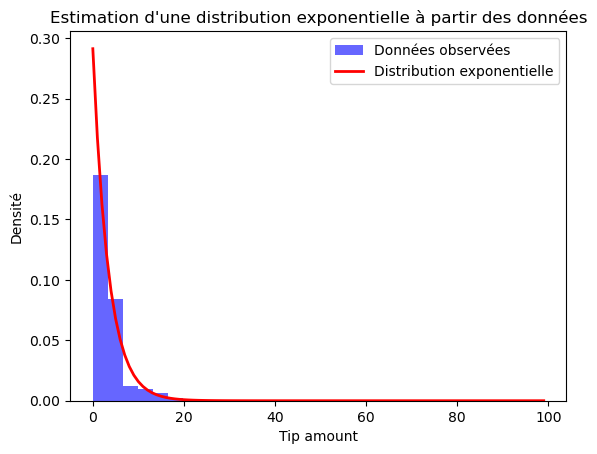

In [453]:
data = df['tip_amount']

# Ajouter une petite valeur aux pouboires nuls car la loi exponentielle >0
data = data.replace(0, 0.01)
mean_tip = data.mean()

# Estimer le paramètre lambda
lambda_estimate = 1 / mean_tip

print("Estimation du paramètre lambda pour la distribution exponentielle :", lambda_estimate)

x = np.linspace(0, data.max(), 100)
y = lambda_estimate * np.exp(-lambda_estimate * x)

# Créer un histogramme des données observées et superposer la distribution exponentielle estimée
plt.hist(data, bins=30, density=True, alpha=0.6, color='blue', label="Données observées")
plt.plot(x, y, 'r-', lw=2, label="Distribution exponentielle")
plt.xlabel("Tip amount")
plt.ylabel("Densité")
plt.title("Estimation d'une distribution exponentielle à partir des données")
plt.legend()
plt.show()

Déterminer quelles sont les variables quantitatives/continues et qualitatives

In [454]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

VendorID: 2
tpep_pickup_datetime: 97567
tpep_dropoff_datetime: 97596
passenger_count: 8
trip_distance: 2412
RatecodeID: 6
store_and_fwd_flag: 2
payment_type: 4
fare_amount: 395
extra: 19
mta_tax: 2
tip_amount: 1808
tolls_amount: 119
improvement_surcharge: 3
congestion_surcharge: 2
Airport_fee: 2
PU_location_lat: 223
PU_location_lon: 223
DO_location_lat: 243
DO_location_lon: 243


In [456]:
# Variable qualitative ou quantitative
quantitative_vars = ['passenger_count','trip_distance', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon', 'fare_amount', 'tolls_amount', 'extra']
qualitative_vars = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']
variable_cible = 'tip_amount'

Verification des variables qualitatives entre train et test

In [615]:
for col in ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']:
    print(col)
    print('Train: ',np.unique(df[col]))
    print('Test: ', np.unique(test[col]))

VendorID
Train:  [1 2]
Test:  [1 2]
RatecodeID
Train:  [ 1.  2.  3.  4.  5. 99.]
Test:  [ 1.  2.  3.  4.  5.  6. 99.]
store_and_fwd_flag
Train:  ['N' 'Y']
Test:  ['N' 'Y']
payment_type
Train:  [1 2 3 4]
Test:  [1 2 3 4]
mta_tax
Train:  [0.  0.5]
Test:  [0.  0.5 4. ]
improvement_surcharge
Train:  [0.  0.3 1. ]
Test:  [0.  0.3 1. ]
congestion_surcharge
Train:  [0.  2.5]
Test:  [0.  1.  2.5]
Airport_fee
Train:  [0.   1.75]
Test:  [0.   1.75]


In [459]:
new_values_in_test = pd.concat([test[test['mta_tax'] == 4.0], test[test['RatecodeID'] == 6.0], test[test['congestion_surcharge']==1.]])
new_values_in_test = new_values_in_test.drop_duplicates()

print(f"Nombres d'observations avec valeurs catégorilles inconnues:{len(new_values_in_test)}")
print(f"Rapport d'observations avec valeurs catégorilles inconnues dans les données test:{len(new_values_in_test)/len(test)}")

Nombres d'observations avec valeurs catégorilles inconnues:5
Rapport d'observations avec valeurs catégorilles inconnues dans les données test:1.9031936731752084e-06


In [460]:
# RatecodeID particularité

In [461]:
np.unique(df['RatecodeID'])

array([ 1.,  2.,  3.,  4.,  5., 99.])

In [462]:
df_ratecode = df[df['RatecodeID']==99.]
print(f"Nombre de pourboires nuls pour le RatecodeID 99: {len(df_ratecode[df_ratecode['tip_amount']==0])}")
print(f"Nombre de pourboires non nuls pour le RatecodeID 99: {len(df_ratecode[df_ratecode['tip_amount']!=0])}")

Nombre de pourboires nuls pour le RatecodeID 99: 968
Nombre de pourboires non nuls pour le RatecodeID 99: 0


In [463]:
# Nombre de passagers

In [464]:
np.unique(df['passenger_count'])

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [465]:
np.unique(test['passenger_count'])

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [466]:
print(f"Nombre d'observations avec 7 passagers: {len(df[df['passenger_count']==5])}")
print(f"Nombre d'observations avec 7 passagers: {len(df[df['passenger_count']==6])}")
print(f"Nombre d'observations avec 8 passagers: {len(df[df['passenger_count']==7])}")

Nombre d'observations avec 7 passagers: 1121
Nombre d'observations avec 7 passagers: 840
Nombre d'observations avec 8 passagers: 1


In [467]:
print(f"Pourboire donné pour l'observation à 8 passagers: {df[df['passenger_count']==7]['tip_amount'].values[0]}")
print(f"Moyenne des pouboires {np.mean(df['tip_amount'])}")

Pourboire donné pour l'observation à 8 passagers: 15.3
Moyenne des pouboires 3.4309846000000004


In [468]:
# Supprime cette observation de nos données
# Nous définissons un nouveau dataframe sur lequel nous faisons des transformations
df_filtered = df.copy()
index_8 = df_filtered[df_filtered['passenger_count']==7].index
df_filtered = df_filtered.drop(index_8, axis=0)

In [469]:
df_filtered

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
0,1,2024-01-15 20:37:28,2024-01-15 20:56:43,1.0,3.30,1.0,N,1,19.1,3.5,0.5,4.80,0.0,1.0,2.5,0.0,40.734576,-74.002875,40.768615,-73.965635
1,2,2024-01-25 19:41:24,2024-01-25 19:44:42,1.0,0.72,1.0,N,1,5.8,2.5,0.5,2.46,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.780436,-73.957012
2,2,2024-01-25 15:48:48,2024-01-25 16:24:23,2.0,7.45,1.0,N,1,38.7,0.0,0.5,3.00,0.0,1.0,2.5,0.0,40.717773,-74.007880,40.780436,-73.957012
3,2,2024-01-27 00:47:26,2024-01-27 00:55:55,1.0,1.53,1.0,N,1,10.0,1.0,0.5,2.25,0.0,1.0,2.5,0.0,40.720889,-73.996919,40.747746,-73.978492
4,2,2024-01-28 13:14:26,2024-01-28 13:22:34,1.0,1.53,1.0,N,1,10.0,0.0,0.5,3.50,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.747746,-73.978492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2,2024-01-19 09:12:12,2024-01-19 09:38:07,1.0,4.38,1.0,N,1,26.1,0.0,0.5,3.00,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.718938,-73.990896
99996,2,2024-01-25 00:07:40,2024-01-25 00:25:13,1.0,5.34,1.0,N,1,25.4,1.0,0.5,6.08,0.0,1.0,2.5,0.0,40.748497,-73.992438,40.706808,-74.007496
99997,1,2024-01-08 09:27:23,2024-01-08 10:01:52,1.0,10.10,99.0,N,1,35.5,0.0,0.5,0.00,0.0,1.0,0.0,0.0,40.857779,-73.885867,40.773633,-73.981532
99998,2,2024-01-06 18:42:49,2024-01-06 19:23:57,1.0,5.82,1.0,N,2,36.6,0.0,0.5,0.00,0.0,1.0,2.5,0.0,40.780436,-73.957012,40.777427,-73.905407


Transformation du dataframe

In [470]:
# Convertir en numérique les colonnes qui devraient l'être
for col in quantitative_vars:
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

for col in qualitative_vars:
    df_filtered[col] = df_filtered[col].astype('category')

# Variable binaire
for col in ['store_and_fwd_flag','VendorID', 'mta_tax', 'congestion_surcharge', 'Airport_fee']:
    df_filtered[col] = pd.factorize(df_filtered[col])[0] + 1

# Variable improvement surcharge
df_filtered['improvement_surcharge'] = pd.factorize(df_filtered['improvement_surcharge'])[0] + 1

# RatecodeID en entiers
df_filtered['RatecodeID'] = df_filtered['RatecodeID'].astype(int)

# Convertir les autres colonnes en type "category" pour les colonnes catégorielles
for col in qualitative_vars:
    df_filtered[col] = df_filtered[col].astype('category')

# Convertion en format data heure
df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])
df_filtered['tpep_dropoff_datetime'] = pd.to_datetime(df_filtered['tpep_dropoff_datetime'])

In [ ]:
# Dataframe avec toutes les valeurs du dataframe
df_long = pd.melt(df_filtered, var_name='Variables', value_name='Values')
df_long_rand = df_long[df_long['Variables'].isin(quantitative_vars+[variable_cible])] 

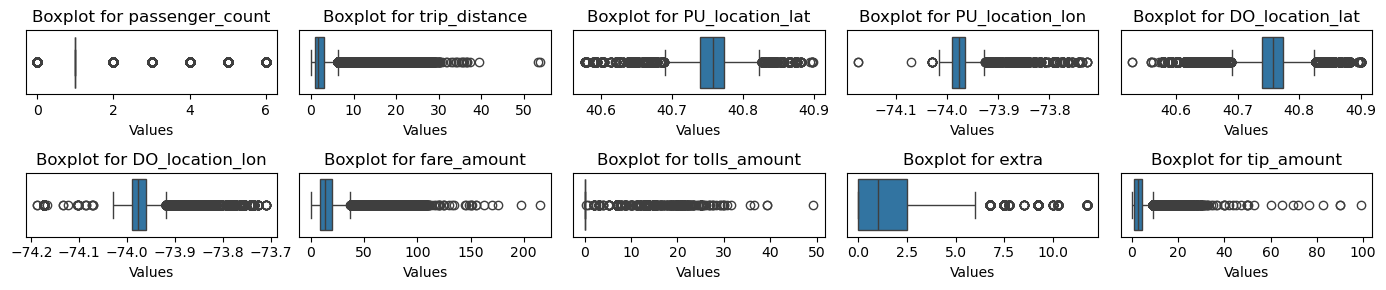

In [472]:
# Définir la taille de la figure pour s'adapter au nombre de sous-graphiques
fig, axes = plt.subplots(2,5, figsize=(14,3))
axes = axes.flatten()

# Tracer un boxplot par variable avec sa propre échelle
for i, var in enumerate(quantitative_vars+[variable_cible]):
    sns.boxplot(data=df_long_rand[df_long_rand['Variables'] == var],x="Values", y="Variables", ax=axes[i],dodge=False)
    axes[i].set_title(f"Boxplot for {var}")
    axes[i].set_ylabel('')
    axes[i].get_yaxis().set_visible(False)
    
# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

## *Corrélation*

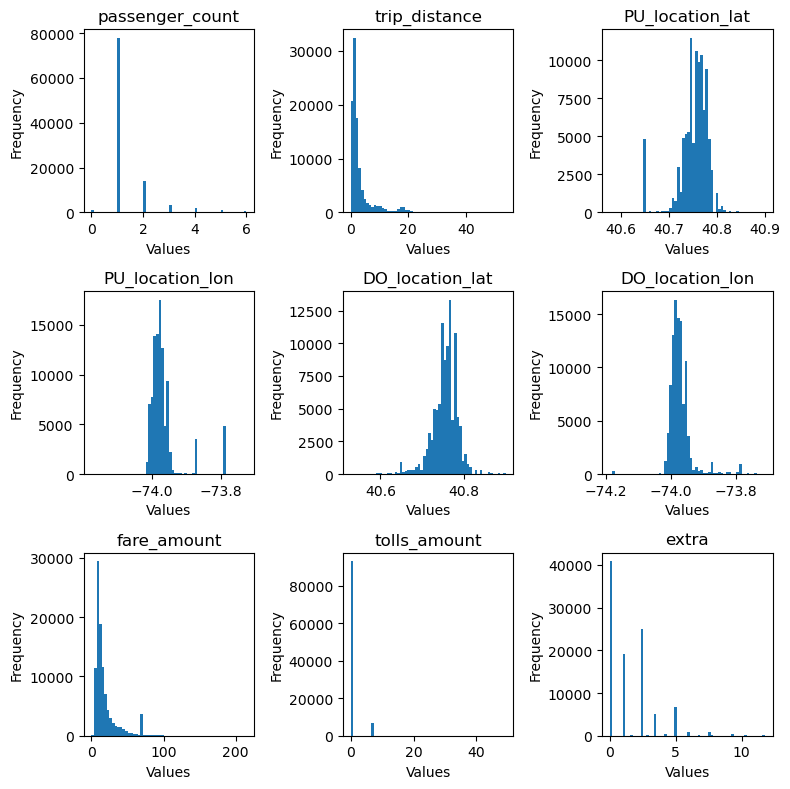

In [473]:
# Distribution des variables quantitatives
fig, axes = plt.subplots(3,3,figsize=(8,8))
axes = axes.flatten()
for i,col in enumerate(quantitative_vars):
  axes[i].hist(df_filtered[col],bins=60)
  axes[i].set_title(col)
  axes[i].set_xlabel('Values')
  axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

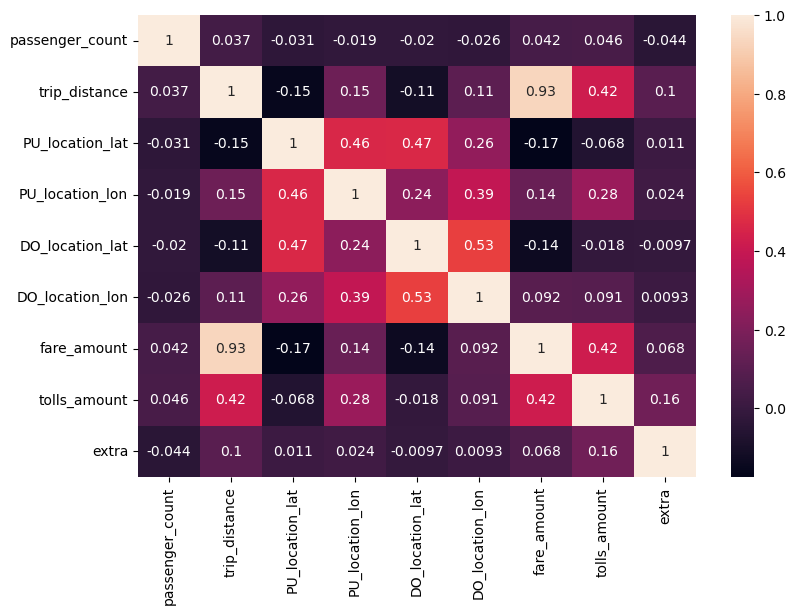

In [474]:
# Matrice des corrélationdes variables quantitatives
df_corr = df_filtered[quantitative_vars].corr(method='spearman')
plt.figure(figsize=(9,6))
sns.heatmap(df_corr,annot=True)
plt.show()

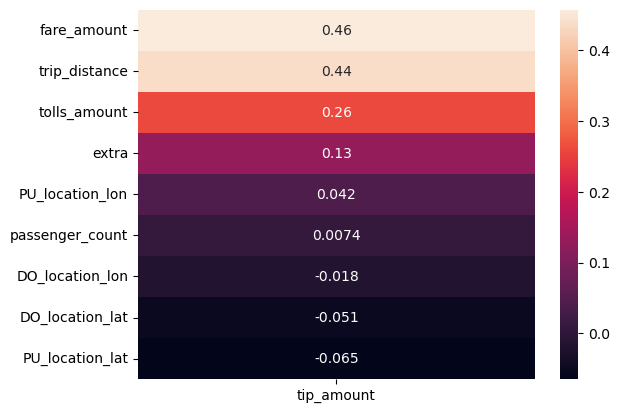

In [475]:
df_corr2 = df_filtered[quantitative_vars+['tip_amount']].corr(method='spearman')
target_spearman_corr = df_corr2[['tip_amount']].drop('tip_amount').sort_values(by='tip_amount', ascending=False)
plt.figure()
sns.heatmap(target_spearman_corr,annot=True)
plt.show()

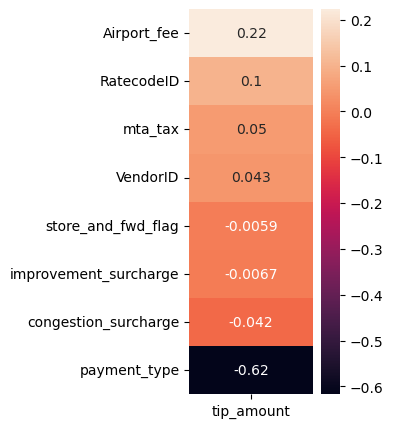

In [476]:
df_corr3 = df_filtered[[var for var in qualitative_vars if var not in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']]+[variable_cible]].corr(method='spearman')
target_spearman_corr2 = df_corr3[[variable_cible]].drop(variable_cible).sort_values(by='tip_amount', ascending=False)
plt.figure(figsize=(2,5))
sns.heatmap(target_spearman_corr2,annot=True)
plt.show()

## ***Importance des variables***





Nous calculons l'importance des variables. Nous excluons **tpep_pickup_datetime** et **tpep_dropoff_datetime** car nous transformerons ces variables plus tard.

Text(0.5, 0, 'Importance')

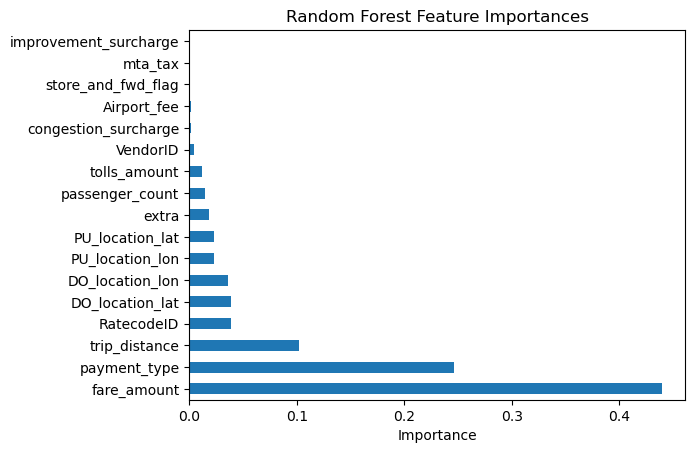

In [477]:
# Via randomForest
X = df_filtered.drop(['tip_amount', 'tpep_pickup_datetime', 'tpep_dropoff_datetime'],axis=1)
y = df_filtered['tip_amount']

# Entrainer un modele de Random Forest
rfc_model = RandomForestRegressor()
rfc_model.fit(X, y)
imp = rfc_model.feature_importances_
forest_imp = pd.Series(imp, index = X.columns)
forest_imp = forest_imp.sort_values(ascending=False)

# Plot les importances
fig = plt.figure()

forest_imp.plot.barh()
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')

# ***Classification***

## Données entraînement et test

In [478]:
df_filtered = df_filtered.reset_index(drop=True)

In [479]:
### Données one hot encoded ###
X = df_filtered.drop(['tip_amount', 'tpep_pickup_datetime', 'tpep_dropoff_datetime'],axis=1)
y = df_filtered['tip_amount']

features = X.columns

## Feature scaling

In [480]:
# Transformé les données
ct_s = StandardScaler()
X_ss = X.copy()
X_ss[quantitative_vars] = ct_s.fit_transform(X_ss[quantitative_vars])
X_ss = pd.DataFrame(X_ss, columns=features)

# Transformé les données
ct_m = MinMaxScaler()
X_mm = X.copy()
X_mm[quantitative_vars] = ct_m.fit_transform(X_mm[quantitative_vars])
X_mm = pd.DataFrame(X_mm, columns=features)

## Entraînement modèles sans configuration

In [481]:
# Partionnement test-train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

features = X_train.columns

In [482]:
# Transformation des données pour répondre aux demandes de XGBoost
# One hot encode les variables catégorielles
def xgboost_data(df, categories):
    df_encoded = pd.get_dummies(df, columns = categories)
    return df_encoded

In [616]:
categories_for_xgb = ['VendorID', 
                      'RatecodeID', 
                      'store_and_fwd_flag', 
                      'payment_type', 
                      'mta_tax', 
                      'improvement_surcharge', 
                      'congestion_surcharge', 
                      'Airport_fee']

### Sur données de base

In [484]:
# Sur données originales

models = {
    "ElasticNet": ElasticNet(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(random_state=42, verbose=0),
    "CatBoost": CatBoostRegressor(random_seed=42, verbose=0, cat_features=categories_for_xgb),
    "Extra Trees Regressor": ExtraTreesRegressor(random_state=42)
}

mse_scores_default = {}
mae_scores_default = {}
r2_scores_default = {}
max_error_scores_default = {}

for method, model in models.items():
    print(method)
    if method == 'SVR':
        index = np.random.randint(0, len(X_train), 5000)
        X_train_subset = X_train.iloc[index]
        y_train_subset = y_train.iloc[index]
        base_model = model.fit(X_train_subset, y_train_subset)
    elif method == 'XGBoost':
        X_train_xgb = xgboost_data(X_train, categories_for_xgb)
        base_model = model.fit(X_train_xgb, y_train)
    else:
        base_model = model.fit(X_train, y_train)

    if method == 'XGBoost':
        X_test_xgb = xgboost_data(X_test, categories_for_xgb)
        y_pred = base_model.predict(X_test_xgb)
    else: 
        y_pred = base_model.predict(X_test)
    
    # Calculate metrics correctly with y_test first
    mse_scores_default[method] = mean_squared_error(y_test, y_pred)
    mae_scores_default[method] = mean_absolute_error(y_test, y_pred)
    r2_scores_default[method] = r2_score(y_test, y_pred)
    max_error_scores_default[method] = max_error(y_test, y_pred)

ElasticNet
Random Forest Regressor
SVR
Gradient Boosting
XGBoost
LightGBM
CatBoost
Extra Trees Regressor


### Données normalisées

In [485]:
# Partionnement test-train
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X_ss, y, test_size=0.3, random_state=42)

In [486]:
# Sur données Standardisées

models = {
    "ElasticNet": ElasticNet(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(random_state=42, verbose=0),
    "CatBoost": CatBoostRegressor(random_seed=42, verbose=0, cat_features=categories_for_xgb),
    "Extra Trees Regressor": ExtraTreesRegressor(random_state=42)
}

mse_scores_default_ss = {}
mae_scores_default_ss = {}
r2_scores_default_ss = {}
max_error_scores_default_ss = {}

for method, model in models.items():
    print(method)
    if method == 'SVR':
        index = np.random.randint(0, len(X_train_ss), 10000)
        X_train_subset = X_train_ss.iloc[index]
        y_train_subset = y_train_ss.iloc[index]
        base_model = model.fit(X_train_subset, y_train_subset)
    elif method == 'XGBoost':
        X_train_xgb = xgboost_data(X_train_ss, categories_for_xgb)
        base_model = model.fit(X_train_xgb, y_train)
    else:
        base_model = model.fit(X_train_ss, y_train_ss)

    if method == 'XGBoost':
        X_test_xgb = xgboost_data(X_test_ss, categories_for_xgb)
        y_pred = base_model.predict(X_test_xgb)
    else: 
        y_pred = base_model.predict(X_test_ss)
    
    # Calculate metrics correctly with y_test first
    mse_scores_default_ss[method] = mean_squared_error(y_test, y_pred)
    mae_scores_default_ss[method] = mean_absolute_error(y_test, y_pred)
    r2_scores_default_ss[method] = r2_score(y_test, y_pred)
    max_error_scores_default_ss[method] = max_error(y_test, y_pred)

ElasticNet
Random Forest Regressor
SVR
Gradient Boosting
XGBoost
LightGBM
CatBoost
Extra Trees Regressor


### Données Min-Max

In [487]:
# Partionnement test-train
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X_mm, y, test_size=0.3, random_state=42)

In [488]:
# Sur données Min-Max

models = {
    "ElasticNet": ElasticNet(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(random_state=42, verbose=0),
    "CatBoost": CatBoostRegressor(random_seed=42, verbose=0, cat_features=categories_for_xgb),
    "Extra Trees Regressor": ExtraTreesRegressor(random_state=42)
}

mse_scores_default_mm = {}
mae_scores_default_mm = {}
r2_scores_default_mm = {}
max_error_scores_default_mm = {}

for method, model in models.items():
    print(method)
    if method == 'SVR':
        index = np.random.randint(0, len(X_train_mm), 10000)
        X_train_subset = X_train_mm.iloc[index]
        y_train_subset = y_train_mm.iloc[index]
        base_model = model.fit(X_train_subset, y_train_subset)
    elif method == 'XGBoost':
        X_train_xgb = xgboost_data(X_train_mm, categories_for_xgb)
        base_model = model.fit(X_train_xgb, y_train)
    else:
        base_model = model.fit(X_train_mm, y_train_mm)

    if method == 'XGBoost':
        X_test_xgb = xgboost_data(X_test_mm, categories_for_xgb)
        y_pred = base_model.predict(X_test_xgb)
    else: 
        y_pred = base_model.predict(X_test_mm)
    
    # Calculate metrics correctly with y_test first
    mse_scores_default_mm[method] = mean_squared_error(y_test, y_pred)
    mae_scores_default_mm[method] = mean_absolute_error(y_test, y_pred)
    r2_scores_default_mm[method] = r2_score(y_test, y_pred)
    max_error_scores_default_mm[method] = max_error(y_test, y_pred)

ElasticNet
Random Forest Regressor
SVR
Gradient Boosting
XGBoost
LightGBM
CatBoost
Extra Trees Regressor


## Performance et comparaisons

In [489]:
# Toutes les métriques
table = PrettyTable()

table.field_names = ['Model', 'MSE', 'MAE', 'r2', 'Max error']

for model in mse_scores_default.keys():
    table.add_row([model, mse_scores_default.get(model, '-'), mae_scores_default.get(model, '-'), r2_scores_default.get(model, '-'), max_error_scores_default.get(model, '-')])

# Print the table
print(table)

table = PrettyTable()

table.field_names = ['Model', 'MSE', 'MAE', 'r2', 'Max error']

for model in mse_scores_default_ss.keys():
    table.add_row([model, mse_scores_default_ss.get(model, '-'), mae_scores_default_ss.get(model, '-'), r2_scores_default_ss.get(model, '-'), max_error_scores_default_ss.get(model, '-')])

# Print the table
print(table)

table = PrettyTable()

table.field_names = ['Model', 'MSE', 'MAE', 'r2', 'Max error']

for model in mse_scores_default_mm.keys():
    table.add_row([model, mse_scores_default_mm.get(model, '-'), mae_scores_default_mm.get(model, '-'), r2_scores_default_mm.get(model, '-'), max_error_scores_default_mm.get(model, '-')])

# Print the table
print(table)

+-------------------------+--------------------+--------------------+---------------------+-------------------+
|          Model          |        MSE         |        MAE         |          r2         |     Max error     |
+-------------------------+--------------------+--------------------+---------------------+-------------------+
|        ElasticNet       | 7.687211583237081  | 1.777332504416833  | 0.43837270410805695 | 86.39511263822578 |
| Random Forest Regressor | 4.6445640589171004 | 1.045816958039803  |  0.6606683808866785 |      86.0271      |
|           SVR           | 9.089003763964323  | 1.6339575352935245 | 0.33595783711245064 | 85.47902405915903 |
|    Gradient Boosting    |  4.16564012412838  | 0.9928677908734345 |  0.6956585397395785 | 85.77938532290463 |
|         XGBoost         | 4.374233569957726  | 1.0094222258442542 |  0.6804187129631982 | 85.77312994003296 |
|         LightGBM        | 4.218133962473932  | 0.9881030654932231 |  0.6918233425212152 |  85.84130063

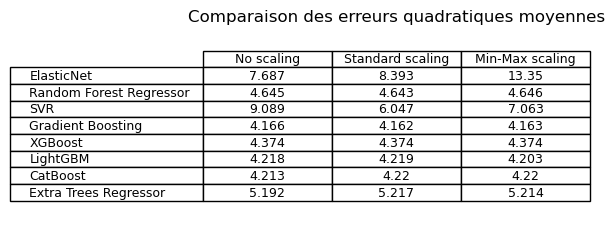

In [ ]:
# Comparaison du mean squared error
mse_scores_default_all = [mse_scores_default.values(), mse_scores_default_ss.values(), mse_scores_default_mm.values()]
mse_scores_default_all = np.array([np.round(list(i),3) for i in mse_scores_default_all]).T

# Plot
fig, ax = plt.subplots(figsize=(5, 2.5)) 
ax.axis('off')

the_table = ax.table(cellText=mse_scores_default_all, colLabels=['No scaling', 'Standard scaling', 'Min-Max scaling'], rowLabels=list(models.keys()), loc='center',cellLoc='center')
plt.title('Comparaison des erreurs quadratiques moyennes')

plt.show()

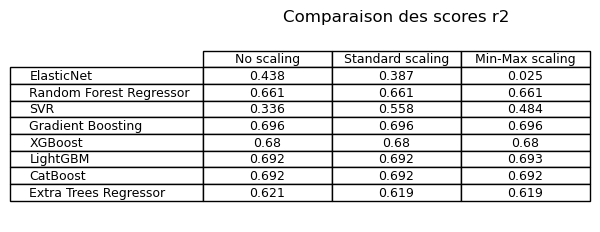

In [ ]:
# Comparaison du r2 score
r2_scores_default_all = [r2_scores_default.values(), r2_scores_default_ss.values(), r2_scores_default_mm.values()]
r2_scores_default_all = np.array([np.round(list(i),3) for i in r2_scores_default_all]).T

# Plot
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.axis('off')

the_table = ax.table(cellText=r2_scores_default_all, colLabels=['No scaling', 'Standard scaling', 'Min-Max scaling'], rowLabels=list(models.keys()), loc='center',cellLoc='center')
plt.title('Comparaison des scores r2')

plt.show()

In [492]:
# Fonction qui ajoute toutes les nouvelles variables
def dataframe_fe(df):
    df_filtered = df.copy()
    # Convertir en numérique les colonnes qui devraient l'être
    for col in quantitative_vars:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

    # Variable binaire
    for col in ['store_and_fwd_flag','VendorID', 'mta_tax', 'congestion_surcharge', 'Airport_fee', 'improvement_surcharge']:
        df_filtered[col] = pd.factorize(df_filtered[col])[0] + 1

    # Variable improvement surcharge
    # df_filtered['improvement_surcharge'] = pd.factorize(df_filtered['improvement_surcharge'])[0] + 1

    # RatecodeID en entiers
    df_filtered['RatecodeID'] = df_filtered['RatecodeID'].astype(int)

    # Convertion en format data heure
    df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])
    df_filtered['tpep_dropoff_datetime'] = pd.to_datetime(df_filtered['tpep_dropoff_datetime'])

    df_filtered = df_filtered.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'], axis=1)

    # Convertir les autres colonnes en type "category" pour les colonnes catégorielles
    for col in categories_for_xgb:
        df_filtered[col] = df_filtered[col].astype('category')

    return df_filtered

## Feature engineering

In [493]:
df_fe = pd.DataFrame()

### Variables temporelles

In [495]:
# Transformation de tpep_pickup_datetime et tpep_dropoff_datetime

In [496]:
# Calculer le temps de trajet + nouvelle variable trajet moyen
df_fe['trip_duration'] = (df_filtered['tpep_dropoff_datetime'] - df_filtered['tpep_pickup_datetime']).dt.total_seconds() / 60

df_fe['average_speed'] = df_filtered['trip_distance']/df_fe['trip_duration']
df_fe = df_fe.drop(['trip_duration'], axis=1)

In [ ]:
# Creer une variable "time_of_day": (matin, midi, soir)
# Nous choisissons de definir matin : 5h-12h, midi : 12h-18h, soir : 18h-5h
def time_of_day(hour):
    if 4 <= hour < 12:
        return 0
    elif 12 <= hour < 18:
        return 1
    else:
        return 2

df_fe['time_of_day'] = df_filtered['tpep_pickup_datetime'].dt.hour.apply(time_of_day)

In [498]:
# Creer une variable binaire indiquant si le trajet a eu lieu pendant le weekend (vendredi compris)
df_fe['is_weekend'] = df_filtered['tpep_pickup_datetime'].dt.dayofweek.apply(lambda x: True if x >= 5 else False)

### Petite analyse de la méthode de paiement

In [500]:
# Pourboire moyen par méthode de paiement
print('Carte de crédit:',np.mean(df_filtered[df_filtered['payment_type']==1]['tip_amount']))
print('Espèce:', np.mean(df_filtered[df_filtered['payment_type']==2]['tip_amount']))
print('Aucune charge:',np.mean(df_filtered[df_filtered['payment_type']==3]['tip_amount']))
print('Litige:',np.mean(df_filtered[df_filtered['payment_type']==4]['tip_amount']))

Carte de crédit: 4.113448354415203
Espèce: 0.0
Aucune charge: 0.0
Litige: 0.001176470588235294


In [501]:
# Il y a une observation avec un pourboire non nul pour une méthode paiement différente de carte de crédit. Potentiel outlier
print(df_filtered.loc[(df_filtered['payment_type'] == 4) & (df_filtered['tip_amount'] == 1)].shape[0])

1


In [502]:
print(f"observations où le paiement a été effectué par carte de crédit {len(df_filtered[df_filtered['payment_type']==1])}")

observations où le paiement a été effectué par carte de crédit 83405


### Données coordonnées

In [503]:
# Clusterisation des quartiers/zones pour point de départ et arrivée
# Appliquer KMeans pour 10 clusters
kmeans_pickup = KMeans(n_clusters=10, random_state=42)
df_fe['pickup_cluster'] = kmeans_pickup.fit_predict(df_filtered[['PU_location_lat', 'PU_location_lon']])

kmeans_dropoff = KMeans(n_clusters=10, random_state=42)
df_fe['dropoff_cluster'] = kmeans_dropoff.fit_predict(df_filtered[['DO_location_lat', 'DO_location_lon']])

### Frais supplémentaires

In [ ]:
# Somme des variables "frais""+ suppression"

df_fe[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']] = df_filtered[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']].apply(pd.to_numeric, errors='coerce')
df_fe['total_extra_fees'] = df_fe[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']].sum(axis=1)
df_fe = df_fe.drop(['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee'], axis=1)

### Fonction de transformation des données

In [573]:
# Transformation du nouveau dataframe
def transform_df_fe(df, km_pickup, km_dropoff):
    # Supprime cette observation de nos données
    # Nous définissons un nouveau dataframe sur lequel nous faisons des transformations
    df_filtered = df.copy()

    # Convertir en numérique les colonnes qui devraient l'être
    for col in quantitative_vars:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

    # Variable catégorielles
    for col in ['store_and_fwd_flag','VendorID', 'mta_tax', 'congestion_surcharge', 'Airport_fee', 'improvement_surcharge']:
        to_map = np.unique(df_filtered[col])
        df_filtered[col] = df_filtered[col].map({to_map[0]: 0, to_map[1]: 1})

    # RatecodeID en entiers
    df_filtered['RatecodeID'] = df_filtered['RatecodeID'].astype(int)

    # Convertir les autres colonnes en type "category" pour les colonnes catégorielles
    for col in qualitative_vars:
        df_filtered[col] = df_filtered[col].astype('category')

    # Feauter engineering
    # Convertion en format data heure
    df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])
    df_filtered['tpep_dropoff_datetime'] = pd.to_datetime(df_filtered['tpep_dropoff_datetime'])

    df_fe = pd.DataFrame()
    # Calculer le temps de trajet + nouvelle variable trajet moyen
    df_fe['trip_duration'] = (df_filtered['tpep_dropoff_datetime'] - df_filtered['tpep_pickup_datetime']).dt.total_seconds() / 60

    # df_fe['average_speed'] = df_filtered['trip_distance']/df_fe['trip_duration']
    df_fe['average_speed'] = np.where(df_fe['trip_duration'] == 0, 0, df_filtered['trip_distance'] / df_fe['trip_duration'])
    
    df_fe = df_fe.drop(['trip_duration'], axis=1)

    # Time of day
    df_fe['time_of_day'] = df_filtered['tpep_pickup_datetime'].dt.hour.apply(time_of_day)

    # Creer une variable binaire indiquant si le trajet a eu lieu pendant le weekend (vendredi compris)
    df_fe['is_weekend'] = df_filtered['tpep_pickup_datetime'].dt.dayofweek.apply(lambda x: True if x >= 5 else False)

    df_fe['pickup_cluster'] = km_pickup.predict(df_filtered[['PU_location_lat', 'PU_location_lon']])
    df_fe['dropoff_cluster'] = km_dropoff.predict(df_filtered[['DO_location_lat', 'DO_location_lon']])

    # Frais supplementaire
    df_fe[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']] = df_filtered[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']].apply(pd.to_numeric, errors='coerce')
    df_fe['total_extra_fees'] = df_fe[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']].sum(axis=1)
    df_fe = df_fe.drop(['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee'], axis=1)

    # to category
    for col in ['time_of_day', 'pickup_cluster', 'dropoff_cluster']:
        df_fe[col] = df_fe[col].astype('category')

    # Enlever les variables inutiles
    to_remove = ['PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon', 'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge','store_and_fwd_flag']
    df_filtered = df_filtered.drop(to_remove, axis=1)

    df_filtered = df_filtered.join(df_fe)

    # def one_hot_encode(df, categories):
    #     df_encoded = pd.get_dummies(df, columns = categories)
    #     return df_encoded
    
    # to_one_hot = ['time_of_day', 'pickup_cluster', 'dropoff_cluster', 'VendorID', 'RatecodeID']
    # df_encoded = one_hot_encode(df_filtered, to_one_hot)

    return df_filtered

### Test des performances des modèles sur données après feature engineering

Les modèles seront entraînés uniquement sur les données pour laquelle le omde de paiement est la carte de crédit

In [595]:
### Données avec methode de paiement: carte de credit (==1)
df_filtered2 = df_filtered[df_filtered['payment_type']==1]

X22 = df_filtered2.drop(['tip_amount'],axis=1)
X22  = transform_df_fe(X22, kmeans_pickup, kmeans_dropoff)
X22 = X22.drop('payment_type', axis=1)

y22 = df_filtered2['tip_amount']

In [523]:
X_tr, X_te, y_tr, y_te = train_test_split(X22, y22, test_size=0.3, random_state=42)

In [524]:
# Sur données originales

models = {
    "XGBoost": XGBRegressor(enable_categorical=True),
    "CatBoost": CatBoostRegressor(random_seed=42, verbose=0, cat_features=['time_of_day', 'pickup_cluster', 'dropoff_cluster', 'VendorID', 'RatecodeID','Airport_fee']),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),    
    "LightGBM": LGBMRegressor(random_state=42, verbose=0),
    "Extra Trees Regressor": ExtraTreesRegressor(random_state=42)
}

mse_scores_fe = {}
mae_scores_fe = {}
r2_scores_fe = {}
max_error_scores_fe = {}

for method, model in models.items():
    print(method)
    if method == 'SVR':
        index = np.random.randint(0, len(X_tr), 5000)
        X_train_subset = X_tr.iloc[index]
        y_train_subset = y_tr.iloc[index]
        base_model = model.fit(X_train_subset, y_train_subset)
    else:
        base_model = model.fit(X_tr, y_tr)

    y_pred = base_model.predict(X_te)
    
    # Calculate metrics correctly with y_test first
    mse_scores_fe[method] = mean_squared_error(y_te, y_pred)
    mae_scores_fe[method] = mean_absolute_error(y_te, y_pred)
    r2_scores_fe[method] = r2_score(y_te, y_pred)
    max_error_scores_fe[method] = max_error(y_te, y_pred)

XGBoost
CatBoost
Random Forest Regressor
SVR
Gradient Boosting
LightGBM
Extra Trees Regressor


In [644]:
mse_scores_comp = []
for method in list(mse_scores_fe.keys()):
    mse_scores_comp.append([mse_scores_default[method], mse_scores_fe[method]])
mse_scores_comp = np.array([np.round(list(i),3) for i in mse_scores_comp])

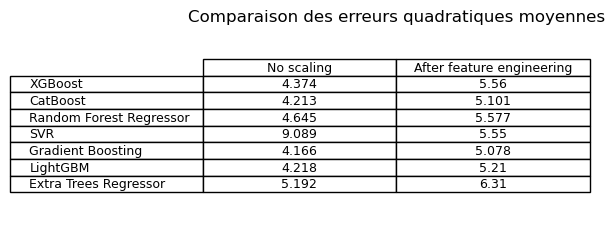

In [646]:
# Plot
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.axis('off')

the_table = ax.table(cellText=mse_scores_comp, colLabels=['No scaling', 'After feature engineering'], rowLabels=list(mse_scores_fe.keys()), loc='center',cellLoc='center')
plt.title('Comparaison des erreurs quadratiques moyennes')

plt.show()

Text(0.5, 0, 'Importance')

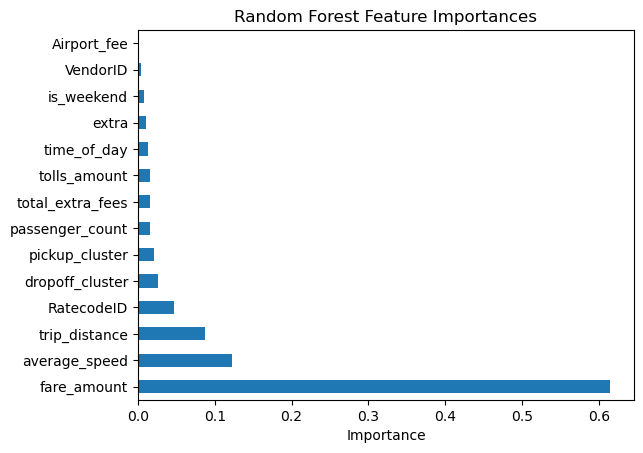

In [526]:
# Importance des variables lors de l'entrainement sur les donnees feature engineered (uniquement carte bancaire)
rfc_model = RandomForestRegressor()
rfc_model.fit(X22, y22)
imp = rfc_model.feature_importances_
forest_imp = pd.Series(imp, index = X22.columns)
forest_imp = forest_imp.sort_values(ascending=False)

# Plot les importances
fig = plt.figure()

forest_imp.plot.barh()
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')

### Optimisation des hyperparametres par Validation Croisee

In [650]:
# Different models

# Return the model with the best performance in cross-validation after grid search (hyperparameters that achieve best cv score)
def tune_hyperparameters(model, method, param_grid, X_train, y_train, cv_folds, scoring):
    gs_model = RandomizedSearchCV(model, param_grid, cv=cv_folds, scoring=scoring, n_jobs=-1, verbose=1)
    gs_model.fit(X_train, y_train)
    return gs_model.best_estimator_, gs_model.best_params_

models = {
    "XGBoost": XGBRegressor(enable_categorical=True),
    "CatBoost": CatBoostRegressor(verbose=0, cat_features=['time_of_day', 'pickup_cluster', 'dropoff_cluster', 'VendorID', 'RatecodeID','Airport_fee']),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "LightGBM": LGBMRegressor(verbose=0)
}

# Hyperparameters to compare during cv
hyperparameter_grids = {
    "XGBoost": {
        'n_estimators': [100, 300, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 6, 10, 15],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.01, 0.1, 1],
        'reg_lambda': [0.5, 1, 1.5, 2]
    },
    
    "CatBoost": {
        'iterations': [200, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7],
        'random_strength': [1, 2, 5, 10],
        'bagging_temperature': [0, 1, 2, 5],
        'border_count': [32, 64, 128]
    },
    
    "Random Forest Regressor": {
        'n_estimators': [100, 300, 500, 1000],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 10],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True]
    },
    
    "Gradient Boosting": {
        'n_estimators': [100, 300, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.6, 0.8, 1.0],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 10]
    },
    
    "LightGBM": {
        'n_estimators': [100, 300, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [-1, 10, 20, 30],
        'num_leaves': [31, 50, 100, 150],
        'min_child_samples': [5, 10, 20, 30],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 1, 10],
        'reg_lambda': [0.5, 1, 1.5, 2]
    }
}

Entrainement uniquement sur les données avec méthode de paiement carte de crédit et avec un RatecodeID différent de 99

In [599]:
### Optimisation sur les donnees d'entrainement pour lequel payment_type=1 (carte de credit)
df_train_fe = df_filtered[df_filtered['payment_type']==1]
df_train_fe = df_train_fe[df_train_fe['RatecodeID']!=99]

X_fe = df_train_fe.drop(['tip_amount'],axis=1)
y_fe = df_train_fe['tip_amount']

X_fe = transform_df_fe(X_fe, kmeans_pickup, kmeans_dropoff)

X_fe = X_fe.drop('payment_type', axis=1)

In [ ]:
cv_folds = 5

tuned_models = {}
best_params = {}

for method,model in models.items():
    print(method)
    tuned_model, params = tune_hyperparameters(model, method, hyperparameter_grids[method], X_fe, y_fe, cv_folds, scoring='neg_mean_squared_error')
    tuned_models[method] = tuned_model
    best_params[method] = params

XGBoost
Fitting 5 folds for each of 10 candidates, totalling 50 fits
CatBoost
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Random Forest Regressor
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Gradient Boosting
Fitting 5 folds for each of 10 candidates, totalling 50 fits
LightGBM
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [603]:
tuned_models

{'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 'CatBoost': <catboost.core.CatBoostRegressor at 0x17299683ce0>,
 'Random Forest Regressor': RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=5,
                       n_estimators=300),
 'Gradient Boosting': G

## Prédiction d'ensemble par moyenne

In [604]:
def predict_tip_amount_ensemble(data, models):
    # Initaliser un vecteur des predictions a 0
    tip_predictions = np.zeros(len(data))
    
    # Predire uniquement les observations avec methode de paiment carte de credit
    payment_type_1 = data[(data['payment_type'] == 1) & (data['RatecodeID'] != 99)]
    payment_type_1 = payment_type_1.drop('payment_type', axis=1)

    if not payment_type_1.empty:
        predictions_ensemble = []

        for method in models:
            print(method)
            pred = models[method].predict(payment_type_1)
            predictions_ensemble.append(pred)

        predictions_ensemble = np.array(predictions_ensemble).astype(float).T
        mean_predictions = np.mean(predictions_ensemble, axis=1)

        tip_predictions[(data['payment_type'] == 1) & (data['RatecodeID'] != 99)] = mean_predictions
    return tip_predictions

In [605]:
new_test = transform_df_fe(test, kmeans_pickup, kmeans_dropoff)

In [606]:
predictions = predict_tip_amount_ensemble(new_test, tuned_models)

XGBoost
CatBoost
Random Forest Regressor
Gradient Boosting
LightGBM


In [607]:
results = pd.DataFrame()
# results['Unnamed: 0'] = np.arange(len(test))
results['row_ID'] = np.arange(len(test))
results['tip_amount'] = predictions
results
results.to_csv('results_taxi.csv', index=False)

### Performance sur les données d'entraînement

In [659]:
new_train = transform_df_fe(df, kmeans_pickup, kmeans_dropoff)

In [661]:
new_y = new_train['tip_amount']
new_train = new_train.drop('tip_amount',axis=1)

In [664]:

predictions_train = predict_tip_amount_ensemble(new_train, tuned_models)
print('Mean squared Error:', mean_squared_error(new_y, predictions_train))
print('R2 score:', r2_score(new_y, predictions_train))

XGBoost
CatBoost
Random Forest Regressor
Gradient Boosting
LightGBM
Mean squared Error: 3.7644898165695113
R2 score: 0.7229946760844349


# Optimisation pour des meilleurs scores dans le leaderboard

Fine tuning sur le score R2

In [651]:
cv_folds = 5

tuned_models_r2 = {}
best_params_r2 = {}

for method,model in models.items():
    print(method)
    tuned_model, params = tune_hyperparameters(model, method, hyperparameter_grids[method], X_fe, y_fe, cv_folds, scoring='r2')
    tuned_models_r2[method] = tuned_model
    best_params_r2[method] = params

XGBoost
Fitting 5 folds for each of 10 candidates, totalling 50 fits
CatBoost
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Random Forest Regressor
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Gradient Boosting
Fitting 5 folds for each of 10 candidates, totalling 50 fits
LightGBM
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [652]:
predictions_r2 = predict_tip_amount_ensemble(new_test, tuned_models_r2)

XGBoost
CatBoost
Random Forest Regressor
Gradient Boosting
LightGBM


In [653]:
results = pd.DataFrame()
# results['Unnamed: 0'] = np.arange(len(test))
results['row_ID'] = np.arange(len(test))
results['tip_amount'] = predictions_r2
results
results.to_csv('results_taxi2.csv', index=False)